# Interaction Testing for Optimizing Neural Network Performance

Interaction testing is most often used to holistically evaluate large systems with various combinations of parameters. In some sense, a neural network can be viewed as such a system. 

## Dataset Orientation and Initial Exploration

First, let's open our dataset, which comes from Kaggle at the following link: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset


In [2]:
import pandas as pd
import numpy as np

full_dataset = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

full_dataset.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Eventually, I want to see a plot of each variable against the other to get an idea of the relationship between each variable. However, this first requires a bit of pre-processing of the data. Because the dataset has over 250,000 entries, this primarily invovles selecting the first 10,000 entries for our dataset. 

In [3]:
dataset = full_dataset.head(10000)

dataset.head()
# binary_columns = ['mainroad','guestroom','basement','hotwaterheating','airconditioning', 'prefarea']

# for col in binary_columns:
#     dataset[col] = dataset[col].apply(lambda x: 0 if x == 'no' else 1)

# dataset.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


The only column left to convert is ```furnishingstatus```, which we'll likewise convert to a numerical value. And yes, later, we'll perform one-hot encoding.

In [3]:
# furnishing_matrix = {
#     "furnished":2,
#     "semi-furnished":1,
#     "unfurnished":0
# }

# dataset['furnishingstatus'] = dataset['furnishingstatus'].apply(lambda x: furnishing_matrix[x])

# dataset.head()

Now, to get an idea of the relationships between each variable, let's use seaborn's built-in ```pairplot``` function.

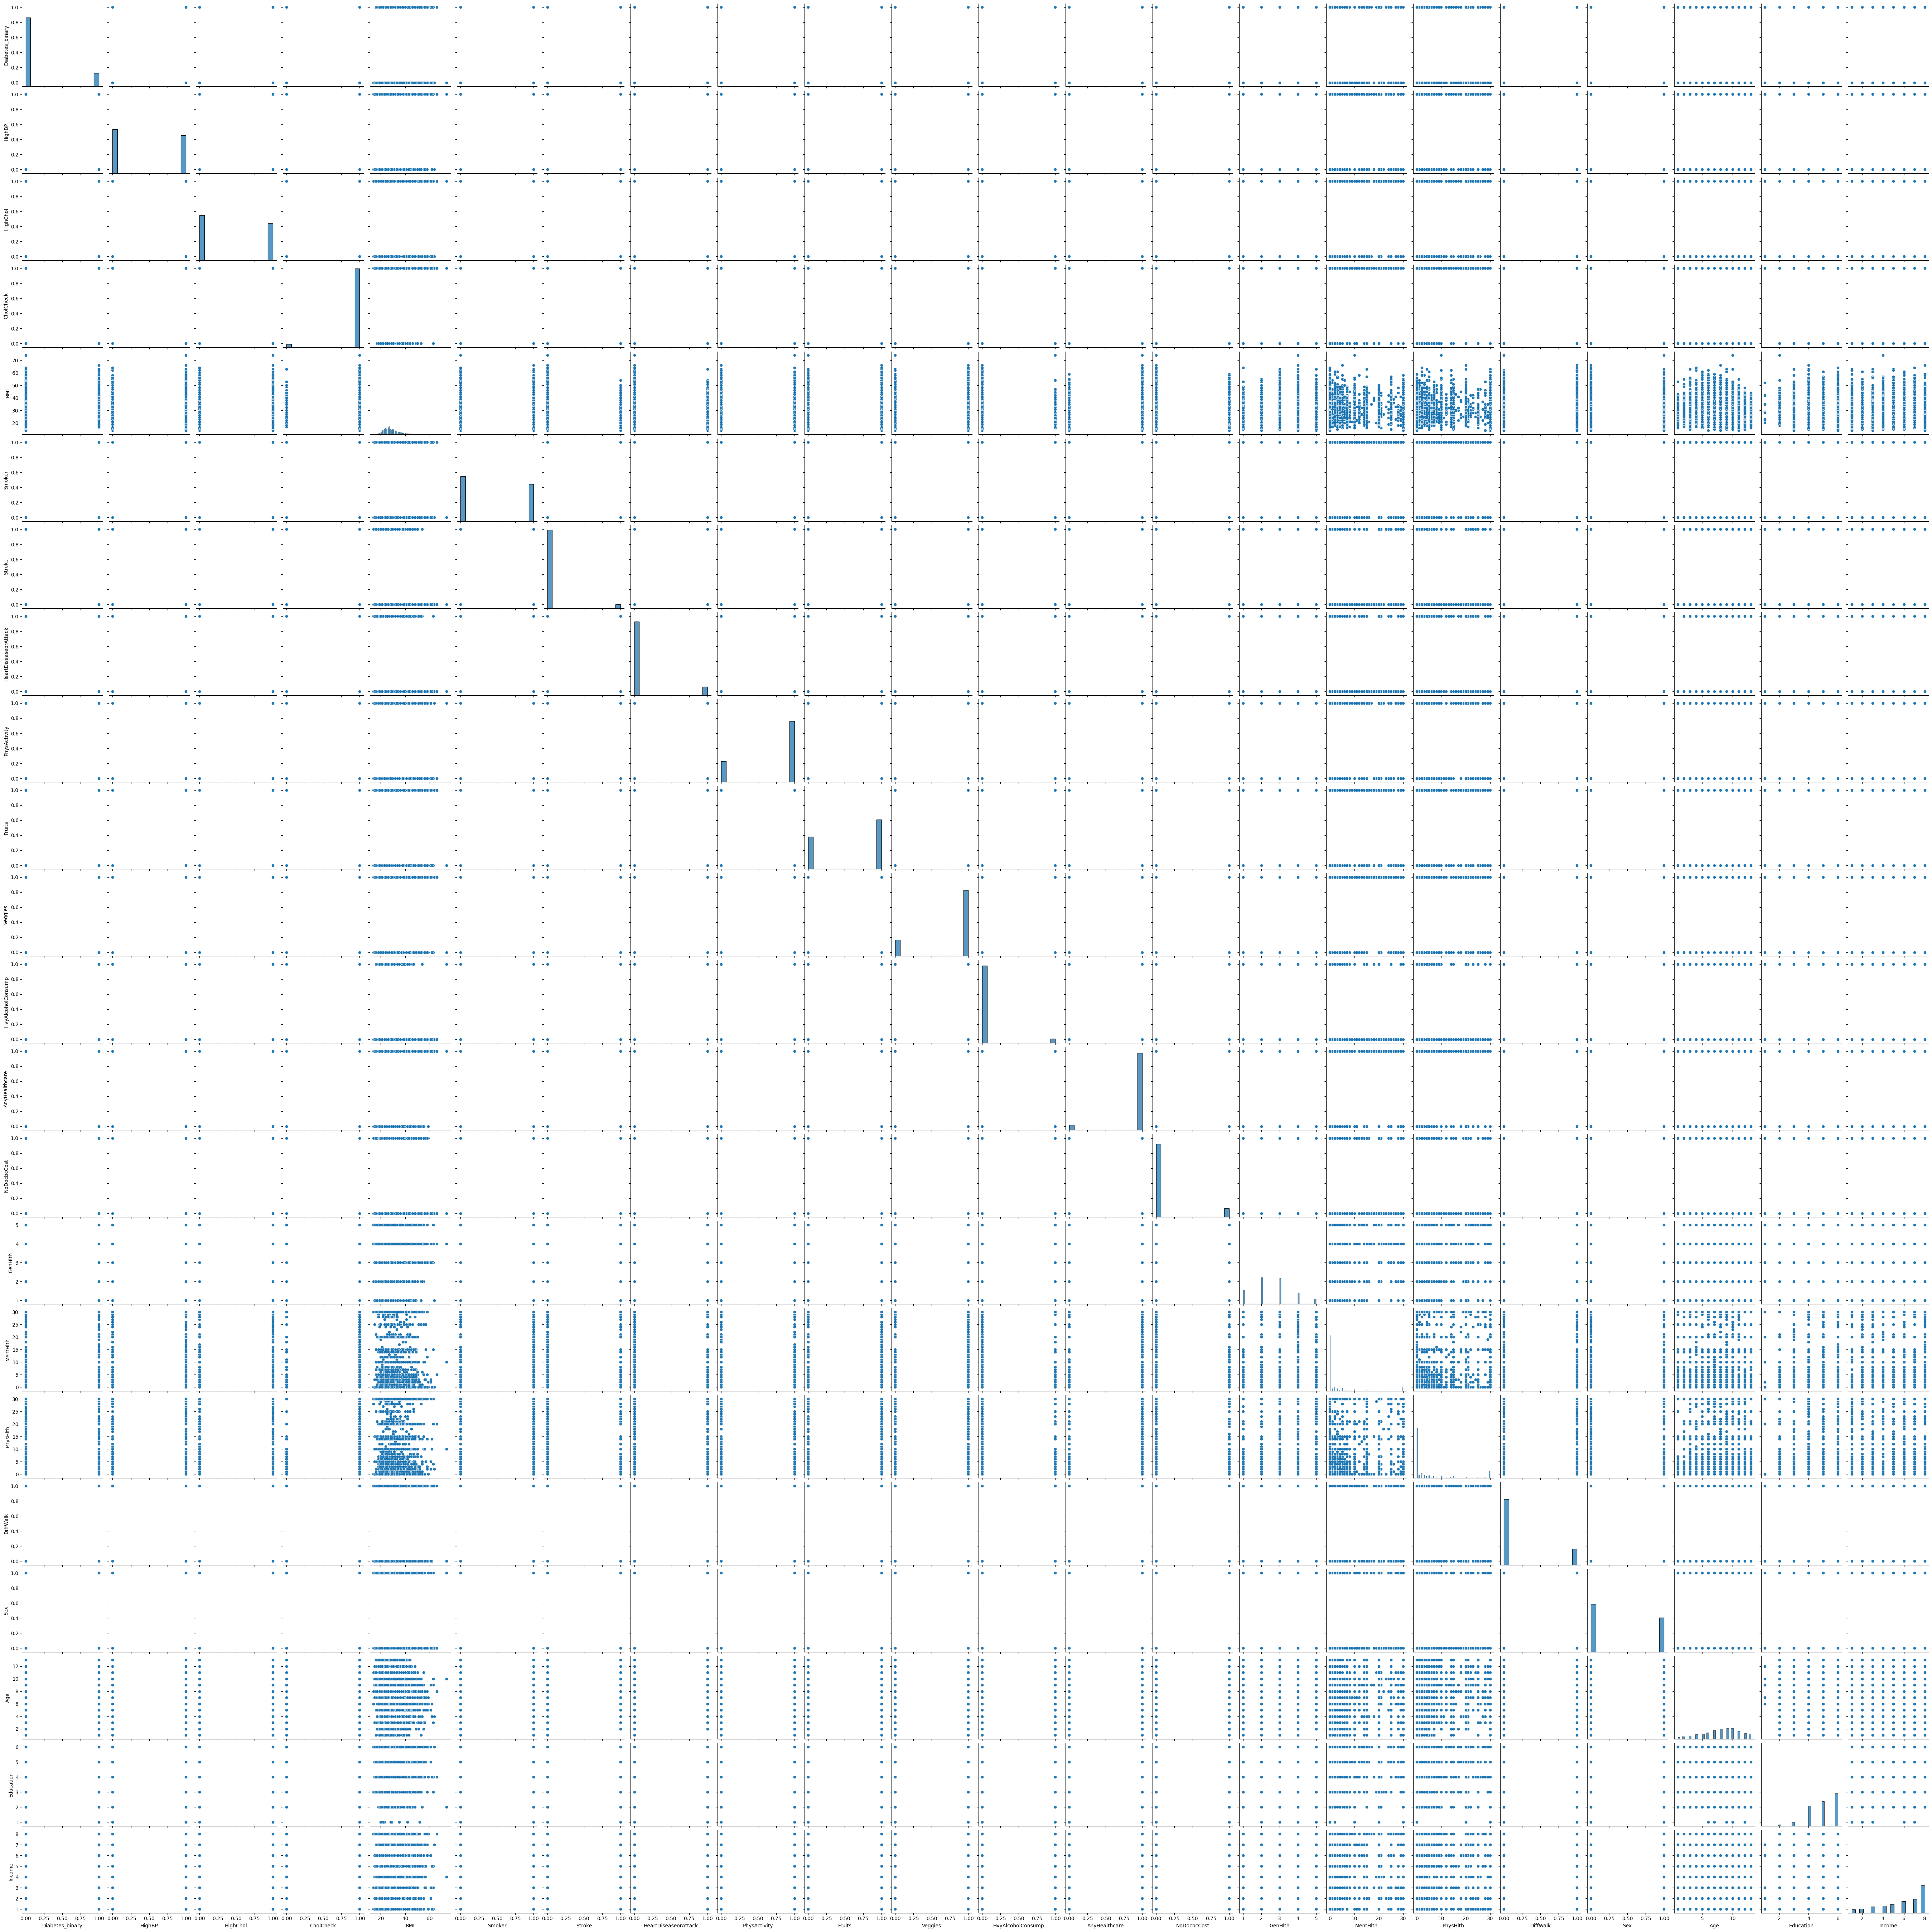

In [4]:
import seaborn as sns

sns.pairplot(dataset)

The most relevant to our course of inquiry is the diagonal line of histograms. Some variables are fairly evenly distributed, such as ```furnishingstatus```, while others are extremely imbalanced, such as ```hotwaterheating```.

Given the prevalence of certain variables over others, it's likely that a model trained on this data would be more accurate for data points that contain variables that show up more often, likely seeing worse performance on rarer variable occurences.

## Building a Baseline Model

Applying the same foundational principle underlying interaction testing to the housing market, it's likely that only a small subset of interactions are responsible for the cost of the house.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

As we're trying to predict diabetes diagnoses, we'll first drop the ```Diabetes_binary``` column to build our explanatory variables ```X``` and response variable ```y```.

In [ ]:
# Define features and target
X = dataset.drop(columns=['Diabetes_binary'])  # Features
y = dataset['Diabetes_binary']  # Target variable

#X.head()
y.head()

#y_avg_unscaled = y.mean()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes_binary, dtype: float64

We then further subdivide the explanatory variables into numerical and categorical features.

In [12]:
# Separate numerical and categorical columns
numerical_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
categorical_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', ]


We then use ```sklearn```'s built-in ```ColumnTransformer``` to scale the numerical and categorical variables appropiately. Using ```StandardScaler```, we scale all values between ```0``` and `1`, and use `OneHotEncoder` on categorial variables.

In [13]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale 'area'
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # One-hot encode categorical
    ]
)

# Apply preprocessing to features
X_preprocessed = preprocessor.fit_transform(X)

# Scale target variable ('price')
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

Finally, we split the data into test and train subsets.

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_scaled, test_size=0.25, random_state=42)
print(X_train.shape, y_train.shape)

(7500, 21) (7500,)


Next, we build and compile the model.

In [15]:

# Build the neural network
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.05), loss='mse', metrics=['mse'])

print(type(X_train), type(y_train))

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=20, batch_size=32, verbose=1)

C:\Users\nikolas.dykstra\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1232 - mse: 1.1232 - val_loss: 0.8445 - val_mse: 0.8445
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8604 - mse: 0.8604 - val_loss: 0.8436 - val_mse: 0.8436
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8354 - mse: 0.8354 - val_loss: 0.8385 - val_mse: 0.8385
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8531 - mse: 0.8531 - val_loss: 0.8496 - val_mse: 0.8496
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8486 - mse: 0.8486 - val_loss: 0.8680 - val_mse: 0.8680
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8586 - mse: 0.8586 - val_loss: 0.8871 - val_mse: 0.8871
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8591 - mse: 0.8591 - val_loss: 0.8943 - val_mse: 0.8943
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8852 - mse: 0.8852 - val_loss: 0.8570 - val_mse: 0.8570
Epoch 9/

Finally, we train the model.

... and then evaluate it.

In [16]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)

In [17]:
# Inverse scale predictions to interpret results
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_unscaled = scaler_y.inverse_transform(model.predict(X_test).reshape(-1, 1)).ravel()

print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Train Loss (MSE): {train_loss:.4f}")
print(f"Train MAE: {train_mae:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Loss (MSE): 0.9367
Test MAE: 0.9367
Train Loss (MSE): 0.9254
Train MAE: 0.9254


To determine whether our model is decent (for some definition of the word decent), we will first compare it against a dummy classifier. This classifier simply predicts the mean of the test set.

In [18]:
mean_price_baseline = y.mean()
baseline_mae = np.mean(np.abs(y_test_unscaled - mean_price_baseline))
print(f"Baseline MAE: {baseline_mae:.2f}")

Baseline MAE: 0.27


In [19]:
y_pred = scaler_y.inverse_transform(model.predict(X_test))
model_mae = np.mean(np.abs(y_test_unscaled - y_pred))
print(f"Model MAE: {model_mae:.2f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
Model MAE: 0.34


Ok, so for now, we don't even beat the baseline. Future research will focus on beating this naieve baseline, but for now, we move on.

## Ensuring Input Diversity

Let's take a look at an input vector.

In [21]:
ca_dataset = dataset.copy().drop(columns=["Diabetes_binary"])
ca_response = dataset["Diabetes_binary"]
ca_dataset.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Let's modify the area column using `pd.qcut`.

In [366]:
n_splits = 3
ca_dataset["area"] = pd.qcut(ca_dataset["area"], q=n_splits, labels=list(range(n_splits)))
ca_dataset

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,2,4,2,3,1,0,0,0,1,2,1,2
1,2,4,4,4,1,0,0,0,1,3,0,2
2,2,3,2,2,1,0,1,0,0,2,1,1
3,2,4,2,2,1,0,1,0,1,3,1,2
4,2,4,1,2,1,1,1,0,1,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
540,0,2,1,1,1,0,1,0,0,2,0,0
541,0,3,1,1,0,0,0,0,0,0,0,1
542,0,2,1,1,1,0,0,0,0,0,0,0
543,0,3,1,1,0,0,0,0,0,0,0,2


Therefore, our input dataset can be represented as a mixed-level covering array whose values have the following properties:

In [22]:
mlca_values = ca_dataset.nunique().tolist()
ca_dataset.nunique()

HighBP                   2
HighChol                 2
CholCheck                2
BMI                     52
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

Now, we need to create a covering array using the rows of our input dataset.

In [23]:
candidate_rows = ca_dataset.values.tolist()

In [24]:
import itertools
import math

def is_a_covering_array(A, mlca_values, t):
    k = len(A[0])

    for col_combo in itertools.combinations(range(k), t):
        # Create a set to store unique t-tuples of values
        unique_tuples = set()
        for row in A:
            tuple_values = tuple(row[i] for i in col_combo)
            unique_tuples.add(tuple_values)

        num_combos = math.prod([mlca_values[col] for col in col_combo])
        
        if len(unique_tuples) < num_combos:
            return False
    return True

In [25]:
is_a_covering_array(candidate_rows, mlca_values, 2)

False

Well, it turns out our original dataset isn't even covering. Let's remove some less-common values to make it so.

In [26]:
candidate_rows = ca_dataset.values.tolist()
mlca_values = ca_dataset.nunique().tolist()
ca_dataset.nunique()

HighBP                   2
HighChol                 2
CholCheck                2
BMI                     52
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

In [27]:
is_a_covering_array(candidate_rows, mlca_values, 2)

False

Ok, this isn't particularily helpful. I've tried ripping values and filtering values, but without grotesquely destroying the input data, there's no chance of creating a covering array. The best I can do is percent coverage, which still ensures input diversity.

In [28]:
def percent_covering(A, mlca_values, t):
    k = len(A[0])

    num_covered_interactions = 0
    total_covered_interactions = 0

    for col_combo in itertools.combinations(range(k), t):
        # Create a set to store unique t-tuples of values
        unique_tuples = set()
        for row in A:
            tuple_values = tuple(row[i] for i in col_combo)
            unique_tuples.add(tuple_values)

        num_combos = math.prod([mlca_values[col] for col in col_combo])

        num_covered_interactions += len(unique_tuples)
        total_covered_interactions += num_combos

    return num_covered_interactions / total_covered_interactions

In [29]:
percent_covering(candidate_rows, mlca_values, 3)

0.35728129216418786

Ok, not bad. The baseline is 72% covering with `t=3`. Let's set a threshold and see how few rows we need to ensure it's covering. And since we can't really modify values within a row, the best we can do is randomly select rows. But again, let's first split into train and test: 

In [474]:
import random

n_iter = 1000
trial_percent = []
t = 3
n_rows = 200

for i in range(n_iter):
    subset = random.sample(candidate_rows, k=n_rows)
    pc = percent_covering(subset, mlca_values, t)
    trial_percent.append(pc)

print(f"Best coverage: {max(trial_percent):.2%}")
print(f"Worst coverage: {min(trial_percent):.2%}")
print(f"Avg coverage: {sum(trial_percent)/len(trial_percent):.2%}")

Best coverage: 61.02%
Worst coverage: 51.46%
Avg coverage: 56.40%


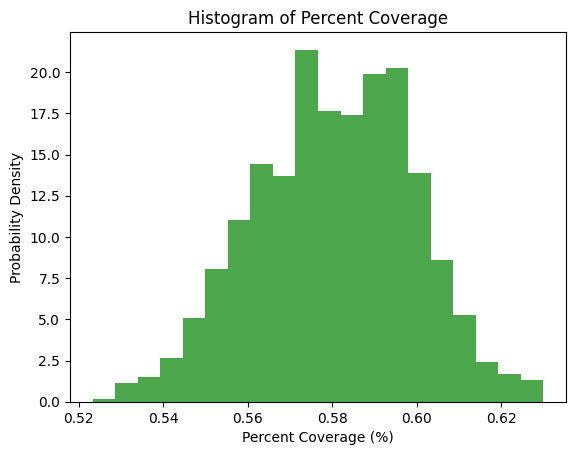

In [404]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(trial_percent, bins=20, density=True, alpha=0.7, color='g')

# Customize the plot
plt.xlabel('Percent Coverage (%)')
plt.ylabel('Probability Density')
plt.title('Histogram of Percent Coverage')

# Show the plot
plt.show()

Exploration into the number of rows is a potential avenue forward. However, as for now, we'll limit it to 150. Most percent coverage variation stays within an 8% spread.

Now, for each subset, we'll fit a model to it, and we'll be able to plot its `mse` against its percent coverage.

In [ ]:
from tqdm import tqdm

n_iter = 200
n_rows = 200
t = 3

results = {}

X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=["price"]), dataset["price"], test_size=0.25)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test_processed = pd.DataFrame(preprocessor.transform(X_test).toarray())
y_test_processed = pd.Series(scaler_y.transform(y_test.values.reshape(-1, 1)).ravel())

n_splits = 4
ca_train = X_train.copy()
ca_train["area"] = pd.qcut(ca_train["area"], q=n_splits, labels=list(range(n_splits)))

mlca_values = ca_train.nunique().tolist()

ca_train = ca_train.values.tolist()

tf.get_logger().setLevel('ERROR')

for trial in range(n_iter):
    # take a n=150 subset of the train dataset
    X_train_subset = X_train.sample(n=min(150, len(X_train)))
    y_train_subset = y_train.loc[X_train_subset.index]
    
    ca_subset = [ca_train[i] for i in X_train_subset.index.tolist()]

    # calculate the percent coverage of the X_train_subset
    pc = percent_covering(ca_subset, mlca_values, t)

    X_train_subset_processed = pd.DataFrame(preprocessor.transform(X_train_subset).toarray())
    y_train_subset_processed = pd.Series(scaler_y.transform(y_train_subset.values.reshape(-1, 1)).ravel())

    # Build the neural network
    model = Sequential([
        Dense(32, activation='relu', input_dim=X_train_subset_processed.shape[1]),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Linear activation for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.05), loss='mse', metrics=['mse'])

    # Train the model
    history = model.fit(X_train_subset_processed, y_train_subset_processed, validation_data=(X_test_processed, y_test_processed), 
                        epochs=50, batch_size=32, verbose=0)
    
    loss, mse = model.evaluate(X_test_processed, y_test_processed, verbose=0) 

    results[trial] = {"percent_coverage": pc,
                      "loss":loss,
                      "mse":mse}


C:\Users\matthew.wanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\matthew.wanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\matthew.wanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\P

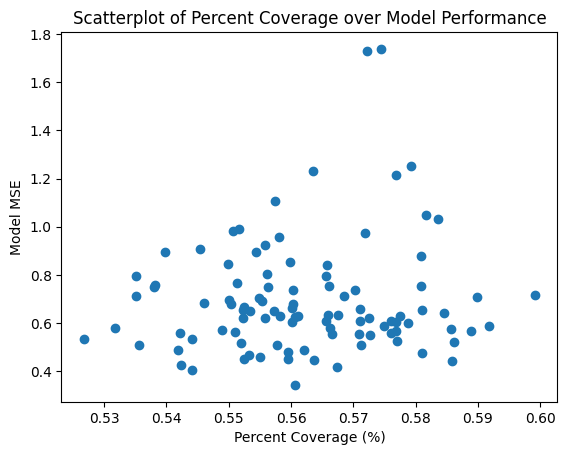

In [473]:
# Create a plot
x = [r["percent_coverage"] for r in results.values()]
y = [r["mse"] for r in results.values()]

plt.scatter(x, y)

# Customize the plot
plt.xlabel('Percent Coverage (%)')
plt.ylabel('Model MSE')
plt.title('Scatterplot of Percent Coverage over Model Performance')

# Show the plot
plt.show()